In [4]:
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim
from collections import Counter
from sklearn.metrics import classification_report
from PIL import Image
import matplotlib.pyplot as plt
import time

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transformations for the training and test data with more aggressive augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the datasets
train_data = datasets.ImageFolder(root='/kaggle/input/chest-xray-pneumonia/chest_xray/train', transform=train_transform)
test_data = datasets.ImageFolder(root='/kaggle/input/chest-xray-pneumonia/chest_xray/val', transform=test_transform)

# Check class distribution
train_counts = Counter(train_data.targets)
test_counts = Counter(test_data.targets)
print(f"Training data distribution: {train_counts}")
print(f"Test data distribution: {test_counts}")

# Create DataLoader objects with weighted sampling to handle class imbalance
sample_weights = [1.0 / train_counts[label] for label in train_data.targets]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
train_loader = DataLoader(train_data, batch_size=32, sampler=sampler)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Load the pre-trained VGG16 model
vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

# Modify the classifier to match the number of classes in the dataset
num_classes = len(train_data.classes)  # Should be 2 for "NORMAL" and "PNEUMONIA"
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, num_classes)

# Move the model to GPU if available
vgg16 = vgg16.to(device)

# Define weighted loss function
class_weights = torch.tensor([1.0 / train_counts[0], 1.0 / train_counts[1]], device=device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Define optimizer with a lower learning rate
optimizer = optim.Adam(vgg16.parameters(), lr=0.0001)

# Training loop
num_epochs = 10
start_time = time.time()
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    vgg16.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_duration = time.time() - epoch_start_time
    train_losses.append(running_loss / len(train_loader))
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]}, Time: {epoch_duration:.2f} seconds')

    # Validate the model
    vgg16.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vgg16(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_losses.append(val_running_loss / len(test_loader))
    print(f'Validation Loss: {val_losses[-1]}, Accuracy: {100 * correct / total:.2f}%')

total_training_time = time.time() - start_time
print(f'Total training time: {total_training_time / 60:.2f} minutes')

# Save the trained model
torch.save(vgg16.state_dict(), 'vgg16_pneumonia.pth')

# Evaluation loop
vgg16.eval()
correct = 0
total = 0

evaluation_start_time = time.time()
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = vgg16(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Print classification report
print(classification_report(all_labels, all_preds, target_names=train_data.classes))

evaluation_duration = time.time() - evaluation_start_time
print(f'Evaluation Time: {evaluation_duration:.2f} seconds')



Training data distribution: Counter({1: 3875, 0: 1341})
Test data distribution: Counter({0: 8, 1: 8})
Epoch 1/10, Loss: 0.1608976748374868, Time: 196.20 seconds
Validation Loss: 0.08675121515989304, Accuracy: 93.75%
Epoch 2/10, Loss: 0.09823722046324297, Time: 197.64 seconds
Validation Loss: 0.33837297558784485, Accuracy: 75.00%
Epoch 3/10, Loss: 0.11946348286165279, Time: 195.97 seconds
Validation Loss: 0.2062404602766037, Accuracy: 100.00%
Epoch 4/10, Loss: 0.05285288306507368, Time: 196.32 seconds
Validation Loss: 0.0855301022529602, Accuracy: 93.75%
Epoch 5/10, Loss: 0.06201947737625155, Time: 196.07 seconds
Validation Loss: 0.17593590915203094, Accuracy: 93.75%
Epoch 6/10, Loss: 0.054644176244208635, Time: 196.88 seconds
Validation Loss: 0.017008451744914055, Accuracy: 100.00%
Epoch 7/10, Loss: 0.043166529810387815, Time: 195.98 seconds
Validation Loss: 0.18953484296798706, Accuracy: 87.50%
Epoch 8/10, Loss: 0.04582352060688934, Time: 195.20 seconds
Validation Loss: 0.004787171259

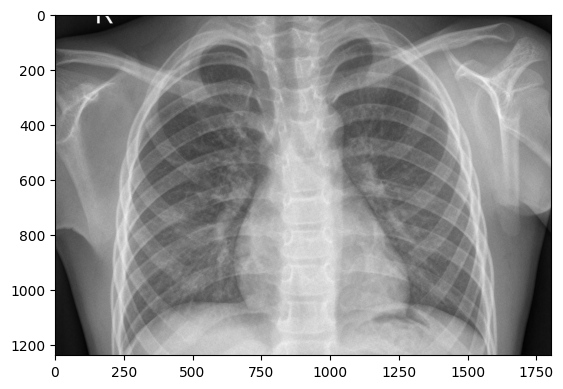

1
Pneumonia


In [14]:
# Test the model on a single image
# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert grayscale to 3-channel image
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the image
# img_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0010-0001.jpeg"
# img_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0010-0001.jpeg"
# img_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0010-0001.jpeg"
img_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0017-0001.jpeg"
img_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0015-0001.jpeg"

img = Image.open(img_path).convert('L')  # Ensure the image is in grayscale
plt.imshow(img, cmap='gray')
plt.show()

# Preprocess the image
img = transform(img)
img = img.unsqueeze(0)  # Add batch dimension
img = img.to(device)

# Load the trained VGG16 model
vgg16 = models.vgg16()
vgg16.classifier[6] = torch.nn.Linear(vgg16.classifier[6].in_features, num_classes)
vgg16.load_state_dict(torch.load('vgg16_pneumonia.pth'))
vgg16 = vgg16.to(device)
vgg16.eval()

# Make a prediction
with torch.no_grad():
    output = vgg16(img)
    _, predicted = torch.max(output, 1)
print(predicted.item())

# Interpret the result
if predicted.item() == 0:
    print("Normal")
else:
    print("Pneumonia")
